In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local').config('spark.driver.memory', '16g').appName('Whole_analysis').getOrCreate()

import pandas as pd
import numpy as np

import psycopg2


def connect_redshift_db():
    cnx = psycopg2.connect(dbname='dwh',
                           host='redshift-prod.data.service.home24.net',
                           port='5439',
                           user='gabriele_sabato',
                           password='zQZ8x6ZhRoTf7GS')
    return cnx


cnx_redshift = connect_redshift_db()
cursor_redshift = cnx_redshift.cursor()


def query_to_dataframe(_cursor, _query):
    _cursor.execute(_query)
    colnames = [desc[0] for desc in _cursor.description]
    print(colnames)
    return pd.DataFrame(_cursor.fetchall(), columns=colnames)


# CREATE MARKET SESSION SPARK DF
sql_query_market_session = """
SELECT report_date, sum(sessions) as session
from public.marketing_daily_dashboard_base
WHERE report_date >= '2020-01-01' and report_date <= '2021-04-28'
group by 1
order by 1
"""

df_marketing_session = query_to_dataframe(cursor_redshift, sql_query_market_session)

df_spark_market_session = spark.createDataFrame(df_marketing_session)

# CREATE MARKET COST SPARK DF
sql_query_market_cost = """
SELECT report_date, sum(cost) as marketing_cost_spend
FROM public.marketing_cost_consolidated
WHERE report_date >= '2020-01-01' and report_date <= '2021-04-28'
AND marketing_channel != 'Sales personnel'
group by 1
order by 1
"""

df_marketing_cost = query_to_dataframe(cursor_redshift, sql_query_market_cost)

df_spark_market_cost = spark.createDataFrame(df_marketing_cost)


['report_date', 'session']
['report_date', 'marketing_cost_spend']


In [2]:
df_marketing_session.tail()


,report_date,session
479,2021-04-24,20087021
480,2021-04-25,25510045
481,2021-04-26,20293537
482,2021-04-27,18437045
483,2021-04-28,16217685


In [3]:
df_marketing_cost.tail()


,report_date,marketing_cost_spend
479,2021-04-24,231455.705590999995943275
480,2021-04-25,315710.252803999996246219
481,2021-04-26,273506.324894999994080725
482,2021-04-27,235772.648319000000015843
483,2021-04-28,222162.568521000000385789


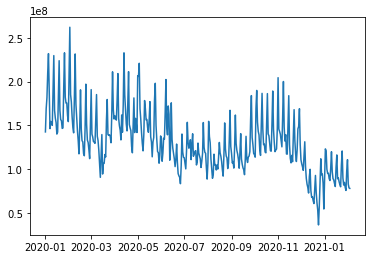

In [4]:
import matplotlib.pyplot as plt

plt.plot(df_marketing_session['report_date'].head(400),df_marketing_session['session'].head(400) )


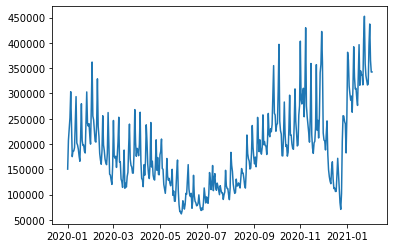

In [5]:
plt.plot(df_marketing_cost['report_date'].head(400),df_marketing_cost['marketing_cost_spend'].head(400))


In [6]:
df = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/price_elasticity_model_data/part-*',
    header=True)


In [7]:
df.createOrReplaceTempView('model_data_table')


In [8]:
df.show()

+------------------+-----------+--------------+-----------+-----+
|         item_code|update_date|delivery_weeks| item_price|sales|
+------------------+-----------+--------------+-----------+-----+
|000000000000001000| 2019-04-04|             1|       19.0|    0|
|000000000000001000| 2019-04-24|             1|       19.0|    0|
|000000001000000008| 2019-07-14|             1|      13.99|    0|
|000000001000000008| 2019-10-03|             1|      13.99|    0|
|000000001000000008| 2020-01-09|             0|      13.99|    0|
|000000001000000013| 2019-02-28|             1|27.98999999|    0|
|000000001000000013| 2019-06-28|             1|      39.99|    0|
|000000001000000013| 2020-10-14|             0|31.98999999|    0|
|000000001000000013| 2021-02-09|             0|      31.99|    0|
|000000001000000014| 2019-07-20|             0|74.98999999|    0|
|000000001000000014| 2020-02-07|             0|74.98999999|    0|
|000000001000000014| 2020-03-02|             1|74.98999999|    0|
|000000001

In [9]:
df_sales = df.toPandas()

In [10]:
df_d_item = spark.read.parquet('/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_item/*')


In [11]:
df_d_item.createOrReplaceTempView('d_item_tmp')

In [12]:
df_item_visits = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/item_visits/*202*/*.parquet',header=True)

In [13]:
df_f_orders = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/f_orders/*.parquet',header=True)

df_f_orders.createOrReplaceTempView('f_orders')

In [14]:
df_d_calendar = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_calendar/*.parquet',header=True)

df_d_calendar.createOrReplaceTempView('d_calendar')



In [15]:
df_d_order_flags = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_order_flags/*.parquet',header=True)

df_d_order_flags.createOrReplaceTempView('d_order_flags')



In [16]:
df_list_top_seller = spark.sql("""
SELECT di.item_code,
       sum(fo.amount + amount_discount) AS order_amount

  FROM f_orders as fo
       INNER JOIN d_calendar c ON c.date_skey = fo.order_date_skey
       INNER JOIN d_item_tmp di ON di.item_skey = fo.item_skey
INNER JOIN d_order_flags dof on dof.order_flags_skey = fo.order_flags_skey

 WHERE c.date >= '2020-01-01' and c.date <= '2021-04-28' --current_date - 1*interval ' 1 year'
and dof.is_cancelled_immediately = 'is not cancelled immediately'
and dof.is_cancelled_after_payment = 'is not cancelled after payment'
and dof.is_cancelled_before_payment = 'is not cancelled before payment'
group by di.item_code
ORDER BY order_amount DESC""")

In [17]:
df_list_top_seller.createOrReplaceTempView('top_seller_list')

#df_list_top_seller.show()



In [18]:
df_list_top_seller_all= spark.sql("""
SELECT item_code
from top_seller_list""")



In [19]:
top_seller_list_string_all = df_list_top_seller_all.rdd.map(lambda x: x.item_code).collect()


In [20]:

N_items = len(top_seller_list_string_all)
print(N_items)

map_of_items = {}


138733


In [21]:
#DEFINE Number of items and get list
print(top_seller_list_string_all)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
def get_list_of_items(top_seller_list = top_seller_list_string_all):
    selected_items = top_seller_list
    selected_items[0]= "'" + selected_items[0]
    selected_items[-1]= selected_items[-1] + "'"
    separator =  "' , '"
    f_string = separator.join(selected_items)
    return f_string



final_string = get_list_of_items()


In [23]:
df_item_visits.createOrReplaceTempView('item_visits')

df_item_visits_df = spark.sql("""SELECT item_code,
                                         meta_date,
                                        SUM(unique_views) as all_unique_views
                                    from item_visits
                                  where item_code in ({lista}) and meta_date <= '2021-04-28'
                                  GROUP BY item_code, meta_date""".format(lista=final_string))
#df_item_visits_df.show()

In [ ]:
df2 = spark.sql("""SELECT *
                    from model_data_table
                    where update_date >= '2020-01-01' and  update_date <= '2021-04-28'
                    and item_code in ({lista})
                    ORDER BY update_date""".format(lista=final_string))
#df2.show()

In [ ]:
df4 = spark.sql ("""SELECT item_code,
                    item_main_category,
                    item_sub_category_1,
                    item_sub_category_2,
                    item_parent_item_code
                    from d_item_tmp
                    where item_code in ({lista})""".format(lista=final_string))
#df4.show()

In [ ]:
df4.createOrReplaceTempView('d_item_filtered')
df2.createOrReplaceTempView('model_data_table_YTD')
df_item_visits_df.createOrReplaceTempView('item_views_YTD')
df_spark_market_session.createOrReplaceTempView('market_session')
df_spark_market_cost.createOrReplaceTempView('market_cost')


In [ ]:
spark.sql("""SELECT COUNT(DISTINCT item_code) from item_views_YTD""").show()
#df_item_visits_df.describe(['item_code']).show()

In [ ]:
sql_price_visit_join = """
SELECT mdt_ytd.*, it_ytd.all_unique_views, ms.session, mc.marketing_cost_spend
FROM model_data_table_ytd as mdt_ytd
LEFT JOIN item_views_ytd as it_ytd
on mdt_ytd.item_code = it_ytd.item_code and mdt_ytd.update_date = it_ytd.meta_date
LEFT JOIN market_session as ms
on mdt_ytd.update_date = ms.report_date
LEFT JOIN market_cost as mc
on mdt_ytd.update_date = mc.report_date
"""
print(sql_price_visit_join)

In [ ]:
df_price_visit_join = spark.sql(sql_price_visit_join)
df_price_visit_join.createOrReplaceTempView('mdt_YTD_it')

#df_price_visit_join.describe(['item_code']).show()
#df_price_visit_join.show()

In [ ]:
sql_top_item_query_group_by = """
WITH tmp_tbl AS (
      SELECT *,
             CASE
                 WHEN lag(delivery_weeks, 1) OVER (PARTITION BY item_code ORDER BY update_date ASC) =
                      delivery_weeks
                     AND
                      lag(item_price, 1) OVER (PARTITION BY item_code ORDER BY update_date ASC) =
                      item_price
                     THEN NULL
                 ELSE RANK() OVER (PARTITION BY item_code ORDER BY update_date)
                 END AS ranking_col --filled with row number or delivery week if the previous one is part of the same group,
        FROM mdt_YTD_it
  ),
       tmp_tbl2 AS (
           SELECT update_date,
                  item_code,
                  sales,
                  all_unique_views,
                  item_price,
                  delivery_weeks,
                  session,
                  marketing_cost_spend,
                  CASE
                      WHEN ranking_col IS NULL
                          THEN last(ranking_col, True) OVER (PARTITION BY item_code ORDER BY update_date ROWS BETWEEN UNBOUNDED PRECEDING and 1 PRECEDING)
                      ELSE ranking_col
                      END AS ranks
             FROM tmp_tbl
       )
SELECT CAST(MIN(update_date) as date)                     AS min_date,
       CAST (MAX(update_date) as date)                    AS max_date,
       item_code,
       item_price,
       delivery_weeks,
       avg(sales) as avg_sales,
       avg(all_unique_views) as avg_unique_views,
       avg(session) as avg_sessions,
       avg(marketing_cost_spend) as avg_marketing_cost_spend,
       CASE WHEN sum(all_unique_views) <> 0 THEN sum(sales)/sum(all_unique_views) ELSE NULL END as conv_rate,
       CAST (datediff(MAX(update_date), MIN(update_date) ) + 1 as int) AS bin
  FROM tmp_tbl2
 GROUP BY ranks, delivery_weeks, item_price, item_code
 ORDER BY item_code, min_date ASC;
"""

In [ ]:
print(sql_top_item_query_group_by)

In [ ]:
sql_top_item_df = spark.sql(sql_top_item_query_group_by)

In [ ]:
#sql_top_item_df.show(5000,False)

In [ ]:
#CREATE A TABLE VIEW FOR Top10 sellers
sql_top_item_df.createOrReplaceTempView('top_sellers')


In [ ]:
#JOIN THE TWO TABLEs
sql_join_query = " SELECT top.*, di.item_parent_item_code, di.item_main_category, di.item_sub_category_1, di.item_sub_category_2" \
                 "        from top_sellers as top " \
                 "INNER JOIN d_item_filtered as di on di.item_code = top.item_code "\
                 "ORDER BY top.min_date ASC"

In [ ]:
print(sql_join_query)


In [ ]:
final_top_seller_df = spark.sql(sql_join_query)

In [ ]:
#final_top_seller_df.show(3000,False)


In [ ]:
#final_top_seller_df.describe(['bin']).show()

In [ ]:
pd_df_top_sellers = final_top_seller_df.toPandas()


In [ ]:
pd_df_top_sellers['log_price'] = np.log(pd_df_top_sellers['item_price']+0.0001)

In [ ]:
pd_df_top_sellers['log_delivery_weeks'] = np.log(pd_df_top_sellers['delivery_weeks']+0.0001)

In [ ]:
pd_df_top_sellers['log_sales'] = np.log(pd_df_top_sellers['avg_sales']+0.0001)


In [ ]:
pd_df_top_sellers['log_avg_unique_views'] = np.log(pd_df_top_sellers['avg_unique_views']+0.0001)


In [ ]:
pd_df_top_sellers['log_conv_rate']= np.log(pd_df_top_sellers['conv_rate']+0.0001)
pd_df_top_sellers['conv_rate']= pd_df_top_sellers['conv_rate']+0.000001

In [ ]:
pd_df_top_sellers['log_avg_sessions'] = np.log(pd_df_top_sellers['avg_sessions'] + 0.0001)

pd_df_top_sellers = pd_df_top_sellers.astype({'avg_marketing_cost_spend': float})

pd_df_top_sellers.dtypes

pd_df_top_sellers['log_avg_marketing_cost_spend'] = np.log(pd_df_top_sellers['avg_marketing_cost_spend'] + 0.0001)

In [ ]:
pd_df_top_sellers.to_pickle('/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit_20210607_pre_campaign.pickle')